# Star/Galaxy/Quasar Classification

## Constructing the Feature Matrix

In [2]:
# Import the needed libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from time import process_time

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Import the data.

stars = pd.read_csv("Data/Stars.csv")
galaxies = pd.read_csv("Data/Galaxies.csv")
qsos = pd.read_csv("Data/QSOs.csv")

dataset = pd.concat([stars, galaxies, qsos], ignore_index = True, sort = False).sample(frac=1).reset_index(drop=True)

In [4]:
# Create the feature matrix and label vector.

X = pd.DataFrame({"u - g" : dataset["u"] - dataset["g"], 
                  "g - r" : dataset["g"] - dataset["r"], 
                  "r - i" : dataset["r"] - dataset["i"], 
                  "i - z" : dataset["i"] - dataset["z"]})
y = pd.DataFrame({"class" : dataset["class"]})

## Exploring the Data

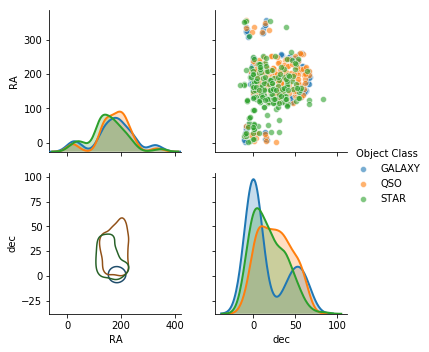

In [27]:
# Plot RA and dec of the data by class.

plot_mat = pd.DataFrame({"RA": dataset["ra"], 
                         "dec": dataset["dec"], 
                         "class": dataset["class"]})
plot_mat = pd.concat([plot_mat.where(plot_mat["class"] == "STAR").dropna().sample(200), 
                      plot_mat.where(plot_mat["class"] == "GALAXY").dropna().sample(200), 
                      plot_mat.where(plot_mat["class"] == "QSO").dropna().sample(200)])

g = sns.PairGrid(plot_mat, hue = "class", hue_order = ["GALAXY", "QSO", "STAR"])
g = g.map_diag(sns.kdeplot, lw = 2, shade = True)
g = g.map_lower(sns.kdeplot, n_levels = 1)
g = g.map_upper(sns.scatterplot, alpha = 0.6)
g = g.add_legend(title = "Object Class")

plt.savefig("Figures/RAdec.png", bbox_inches = "tight");

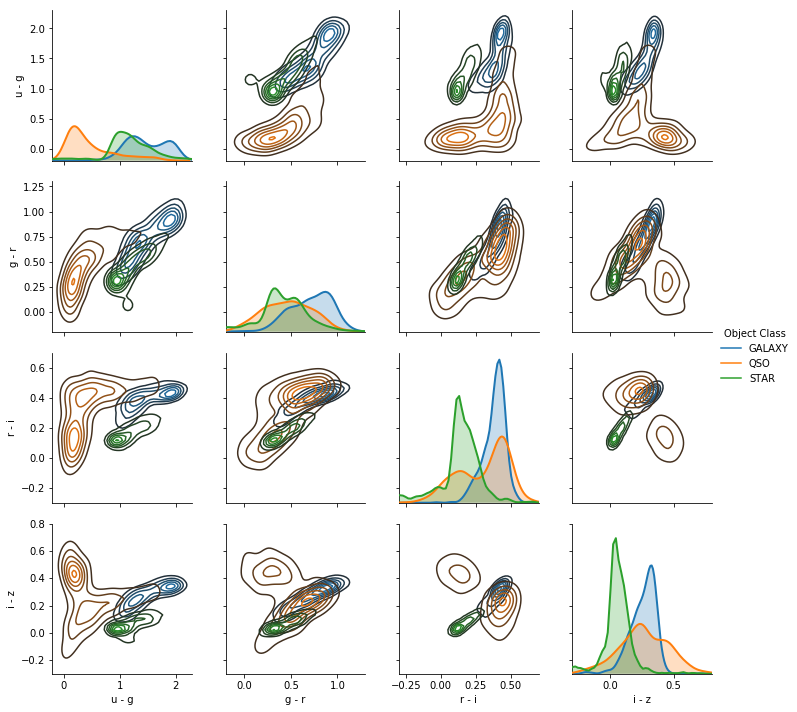

In [16]:
# Creates a corner plot of the data by class 
# using kernel density estimation.

plot_mat = X.join(y)
plot_mat = pd.concat([plot_mat.where(plot_mat["class"] == "STAR").dropna().sample(1000), 
                      plot_mat.where(plot_mat["class"] == "GALAXY").dropna().sample(1000), 
                      plot_mat.where(plot_mat["class"] == "QSO").dropna().sample(1000)])

g = sns.PairGrid(plot_mat, hue = "class", hue_order = ["GALAXY", "QSO", "STAR"])
g = g.map_diag(sns.kdeplot, lw = 2, shade = True)
g = g.map_lower(sns.kdeplot, n_levels = 6)
g = g.map_upper(sns.kdeplot, n_levels = 6)
g = g.add_legend(title = "Object Class")

g.axes.flat[0].set_xlim((-0.2, 2.3))
g.axes.flat[1].set_xlim((-0.2, 1.3))
g.axes.flat[2].set_xlim((-0.3, 0.7))
g.axes.flat[3].set_xlim((-0.3, 0.8))

g.axes.flat[0].set_ylim((-0.2, 2.3))
g.axes.flat[4].set_ylim((-0.2, 1.3))
g.axes.flat[8].set_ylim((-0.3, 0.7))
g.axes.flat[12].set_ylim((-0.3, 0.8))

plt.savefig("Figures/ColorColor.png", bbox_inches = "tight");

In [11]:
X.corr()

,u - g,g - r,r - i,i - z
u - g,1.000000,0.745133,0.450955,0.356000
g - r,0.745133,1.000000,0.697785,0.545970
r - i,0.450955,0.697785,1.000000,0.139737
i - z,0.356000,0.545970,0.139737,1.000000


## Testing Classifiers

### Creating Testing and Training Sets

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

### Creating the Test Method

In [6]:
def scoreAndConf(clf, X_train, X_test, y_train, y_test, title):
    start = process_time()
    clf.fit(X_train, np.asarray(y_train).T[0])
    end = process_time()
    time = np.log10(end - start)
    print("Log time to fit: {}".format(time))
    
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names = ["STAR", "GALAXY", "QUASAR"]))
    
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    
    plot = plt.figure(figsize = (6,6))
    hmap = sns.heatmap(cm_norm, vmin = 0, vmax = 1, fmt = 'd', annot = cm, cmap = "viridis", square = True, 
                       xticklabels = ["STAR", "GALAXY", "QUASAR"], yticklabels = ["STAR", "GALAXY", "QUASAR"])
    hmap.set_xlabel("Predicted", fontsize = 12)
    hmap.set_ylabel("True", fontsize = 12)
    
    plt.savefig("Figures/" + title + ".png", bbox_inches = "tight");
    
    return plot, time

def plotLearn(estimator, X, y, title, cv = None, n_jobs = None, train_sizes = 0.8 * np.logspace(2.6, 5, 10) / 1e5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, np.asarray(y).T[0], cv = cv, n_jobs = n_jobs, 
                                                            train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)

    plot =plt.figure(figsize = (6,6))
    
    plt.grid()
    
    plt.semilogx(train_sizes, train_scores_mean, 'o-', color = "C0",
             label = "Training")
    plt.semilogx(train_sizes, test_scores_mean, 'o-', color = "C1",
             label = "Testing")
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha = 0.6,
                     color = "C0")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.6, 
                     color = "C1")
    
    plt.xlabel("Training examples", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.legend(loc = "best", fontsize = 12)
    
    plt.savefig("Figures/" + title + ".png", bbox_inches = "tight");
    
    return plot

### Gaussian Naive Bayes

Log time to fit: -0.18293068358598671
              precision    recall  f1-score   support

        STAR       0.69      0.82      0.75     16495
      GALAXY       0.92      0.52      0.66      3411
      QUASAR       0.87      0.83      0.85     30570

   micro avg       0.81      0.81      0.81     50476
   macro avg       0.83      0.72      0.75     50476
weighted avg       0.82      0.81      0.81     50476



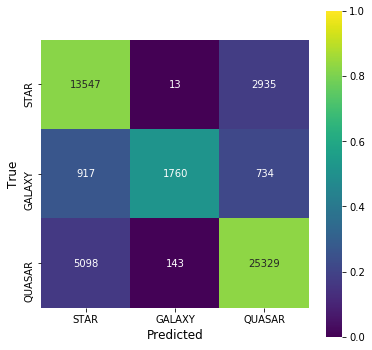

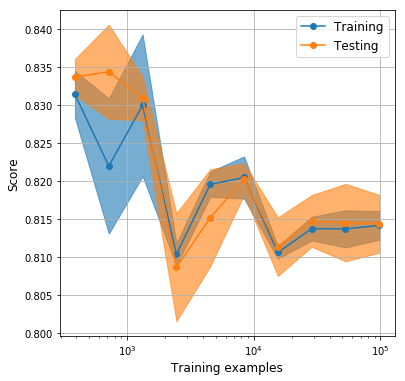

In [7]:
clf_gnb = GaussianNB()
hmap_gnb, time_gnb = scoreAndConf(clf_gnb, X_train, X_test, y_train, y_test, title = "clf_gnb")
lc_gnb = plotLearn(clf_gnb, X = X, y = y, cv = 5, title = "lc_gnb")

### Kernel Support Vector Machine

Log time to fit: 1.2410948934002923
              precision    recall  f1-score   support

        STAR       0.95      0.97      0.96     16495
      GALAXY       0.96      0.85      0.90      3411
      QUASAR       0.99      0.99      0.99     30570

   micro avg       0.97      0.97      0.97     50476
   macro avg       0.96      0.93      0.95     50476
weighted avg       0.97      0.97      0.97     50476



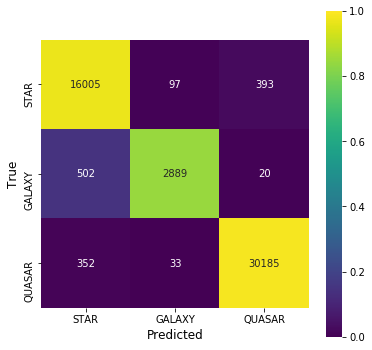

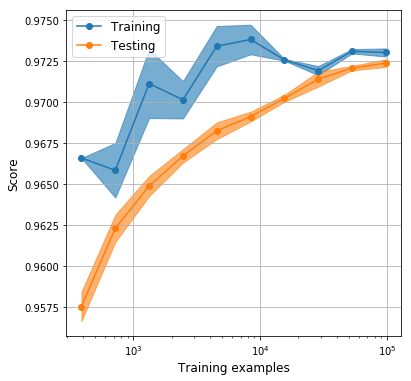

In [8]:
clf_ksvm = SVC(gamma = "auto")
hmap_ksvm, time_ksvm = scoreAndConf(clf_ksvm, X_train, X_test, y_train, y_test, title = "clf_ksvm")
lc_ksvm = plotLearn(clf_ksvm, X = X, y = y, cv = 5, title = "lc_ksvm")

### Linear Discriminant Analysis

Log time to fit: -0.630088714928206
              precision    recall  f1-score   support

        STAR       0.93      0.90      0.91     16495
      GALAXY       0.91      0.83      0.87      3411
      QUASAR       0.95      0.97      0.96     30570

   micro avg       0.94      0.94      0.94     50476
   macro avg       0.93      0.90      0.91     50476
weighted avg       0.94      0.94      0.94     50476



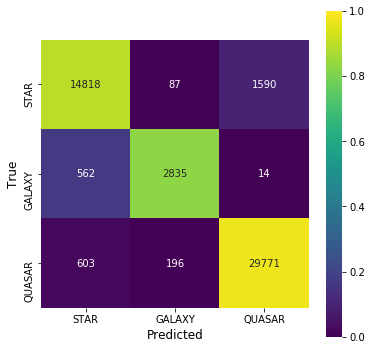

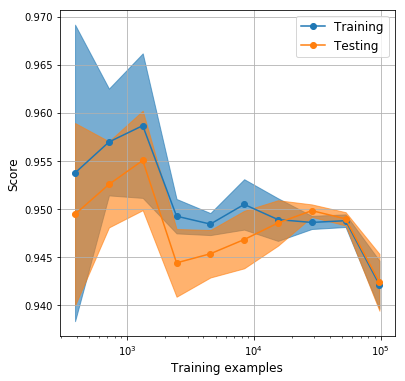

In [9]:
clf_lda = LinearDiscriminantAnalysis()
hmap_lda, time_lda = scoreAndConf(clf_lda, X_train, X_test, y_train, y_test, title = "clf_lda")
lc_lda = plotLearn(clf_lda, X = X, y = y, cv = 5, title = "lc_lda")

### Quadratic Discriminant Analysis

Log time to fit: -0.7269987279362623
              precision    recall  f1-score   support

        STAR       0.91      0.93      0.92     16495
      GALAXY       0.94      0.84      0.89      3411
      QUASAR       0.96      0.96      0.96     30570

   micro avg       0.94      0.94      0.94     50476
   macro avg       0.94      0.91      0.92     50476
weighted avg       0.95      0.94      0.94     50476



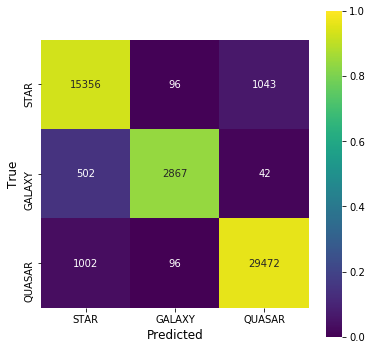

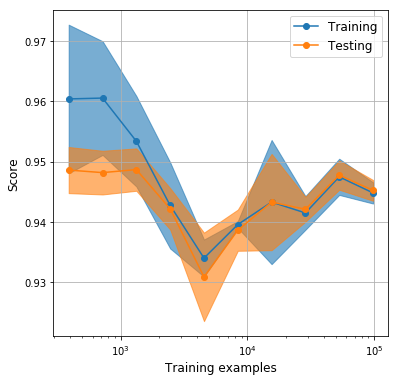

In [10]:
clf_qda = QuadraticDiscriminantAnalysis()
hmap_qda, time_qda = scoreAndConf(clf_qda, X_train, X_test, y_train, y_test, title = "clf_qda")
lc_qda = plotLearn(clf_qda, X = X, y = y, cv = 5, title = "lc_qda")

### K-Nearest Neighbors

Log time to fit: -0.8519374645445623
              precision    recall  f1-score   support

        STAR       0.96      0.97      0.96     16495
      GALAXY       0.93      0.87      0.90      3411
      QUASAR       0.99      0.99      0.99     30570

   micro avg       0.97      0.97      0.97     50476
   macro avg       0.96      0.94      0.95     50476
weighted avg       0.97      0.97      0.97     50476



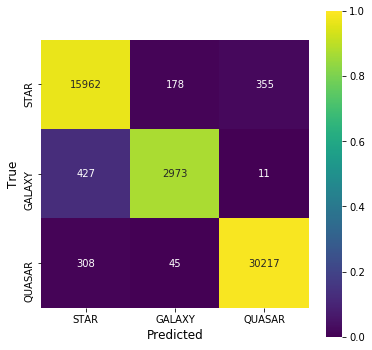

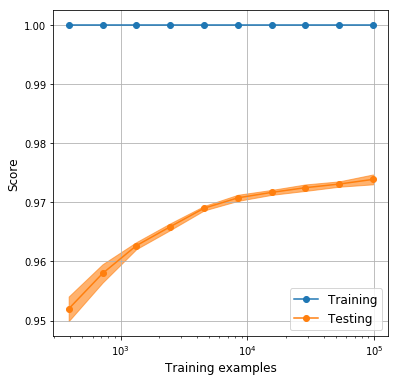

In [11]:
clf_knn = KNeighborsClassifier(n_neighbors = 5, weights = "distance")
hmap_knn, time_knn = scoreAndConf(clf_knn, X_train, X_test, y_train, y_test, title = "clf_knn")
lc_knn = plotLearn(clf_knn, X = X, y = y, cv = 5, title = "lc_knn")

### Decision Tree

Log time to fit: -0.13408211604816972
              precision    recall  f1-score   support

        STAR       0.94      0.94      0.94     16495
      GALAXY       0.85      0.86      0.85      3411
      QUASAR       0.98      0.98      0.98     30570

   micro avg       0.96      0.96      0.96     50476
   macro avg       0.92      0.93      0.93     50476
weighted avg       0.96      0.96      0.96     50476



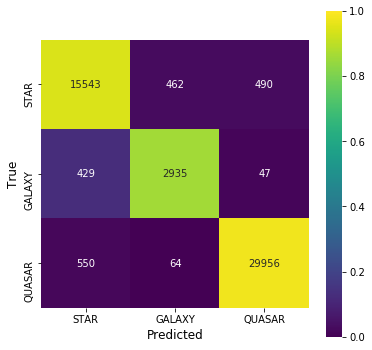

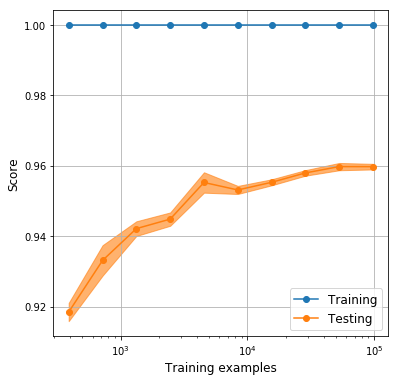

In [12]:
clf_dt = DecisionTreeClassifier()
hmap_dt, time_dt = scoreAndConf(clf_dt, X_train, X_test, y_train, y_test, title = "clf_dt")
lc_dt = plotLearn(clf_dt, X = X, y = y, cv = 5, title = "lc_dt")